# PINN for Poisson equation
# With RAD adaptive sampling with fixed domain sampling interval
$$
\nabla^2 u = f
$$



In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check device (use MPS if on silicon Mac or CUDA if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [53]:
# print device
print(f"Using device: {device}")


Using device: mps


In [54]:
# Define the analytical solution
def analytical_solution(x, y):
    return torch.sin(4 * np.pi * (x + y)) + torch.cos(4 * np.pi * x * y)


In [55]:
# Define the model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

    def forward(self, xy):
        # xy represents the coordinates (x, y) concatenated
        u = self.net(xy)
        return u

def laplacian(u, xy):
    # Compute gradients du/dx and du/dy
    grads = torch.autograd.grad(outputs=u, inputs=xy, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    # Compute second derivatives 
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True, retain_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True, retain_graph=True)[0][:, 1]
    
    laplacian = u_xx + u_yy
    return laplacian 

def loss_pinn(model, xy, x_boundary, u_boundary, f):
    xy = xy.clone().detach().requires_grad_(True)
    x_boundary = x_boundary.clone().detach().requires_grad_(True)
    f = f.clone().detach()
    #predictions
    u = model(xy)
    #compute laplacian
    laplacian_u = laplacian(u, xy)
    physical_loss = torch.mean((laplacian_u - f)**2)
    # boundary condition loss
    u_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((u_boundary_pred - u_boundary)**2)
    return physical_loss + 10* boundary_loss, physical_loss, boundary_loss


def compute_residuals(model, points):
    points = points.clone().detach().requires_grad_(True)
    u = model(points)
    laplacian_u = laplacian(u, points)
    u_analytical = analytical_solution(points[:, 0], points[:, 1])
    f = laplacian(u_analytical, points)
    residuals = torch.abs(laplacian_u - f)
    return residuals.detach()


def compute_pdf(residuals, k=1, c=1):

    # Raise residuals to the power of k
    weighted_residuals = residuals ** k
    
    # Compute the expectation of weighted residuals
    expectation = torch.mean(weighted_residuals)
    
    # Compute the PDF with the added constant c
    pdf = weighted_residuals / expectation + c
    return pdf


def adaptive_sampling(model, n_points, k=1, c=1):
    # Generate candidate points
    n_dense = 50000
    candidates = torch.rand((n_dense, 2), device=device)
    
    # Compute residuals for all candidates
    residuals = compute_residuals(model, candidates)
    
    pdf = compute_pdf(residuals, k, c)
    probabilities = pdf / torch.sum(pdf)
    indices = torch.multinomial(probabilities.flatten(), n_points, replacement=False)
    sampled_points = candidates[indices]
    
    return sampled_points


In [56]:
# Problem setup
# Interior points (uniformly sampled within [0 , 1] x [0, 1])
x_interior = torch.rand((1000, 2), device=device)  # Random points in [0, 1] x [0, 1]
# f is the source term i.e. laplactian of u
x_interior = x_interior.requires_grad_(True)
u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
f = laplacian(u_analytical, x_interior)
x_interior.requires_grad_(False) 

# Boundary points
#x_boundary_x = torch.linspace(0, 1, 250, device=device).unsqueeze(1)
n_boundary_points = 1000
n_boundary_points_per_side = n_boundary_points // 4

x_boundary_x = torch.rand((n_boundary_points_per_side, 1), device=device) * 1.0
x_boundary = torch.cat([
    torch.cat([x_boundary_x, torch.zeros_like(x_boundary_x)], dim=1),
    torch.cat([x_boundary_x, torch.ones_like(x_boundary_x)], dim=1),
    torch.cat([torch.zeros_like(x_boundary_x), x_boundary_x], dim=1),
    torch.cat([torch.ones_like(x_boundary_x), x_boundary_x], dim=1),
], dim=0)

# Boundary condition values using the analytical solution
u_boundary = analytical_solution(x_boundary[:, 0], x_boundary[:, 1]).unsqueeze(1).to(device)




In [57]:
print(u_boundary.shape)
print(x_interior.shape)    


torch.Size([1000, 1])
torch.Size([1000, 2])


In [58]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

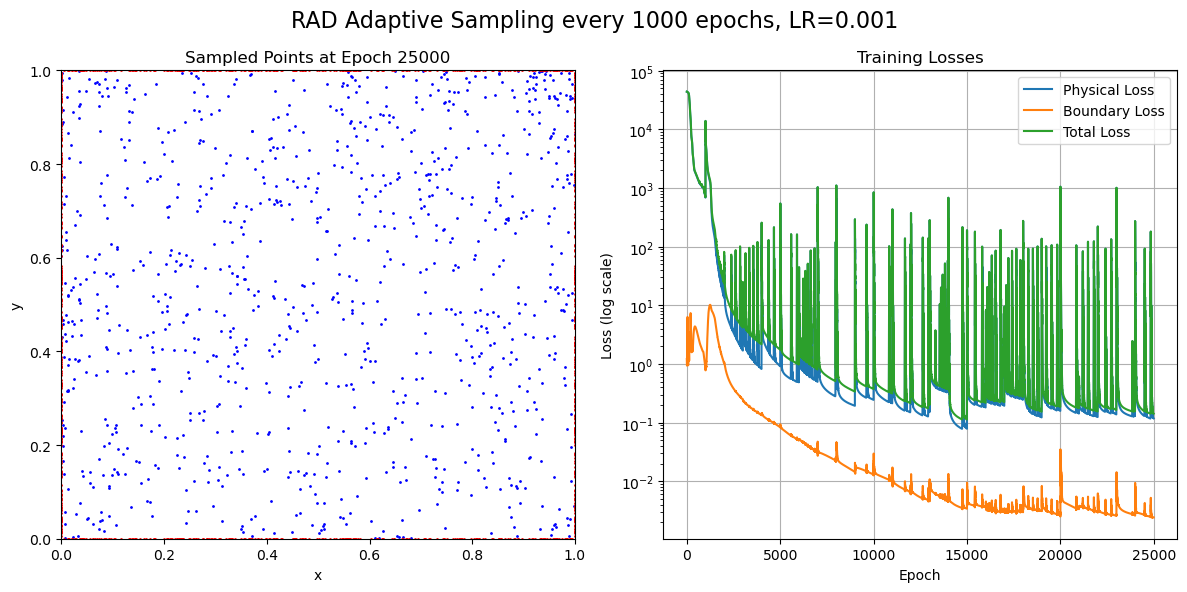

In [59]:

# Training
num_epochs = 25000
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


n_interior_points = 1000
physical_losses = []
boundary_losses = []
total_losses = []



# Define the resampling interval (in epochs)
resampling_interval = 1000  # Resample every 100 epochs

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss, physical_loss, boundary_loss = loss_pinn(model, x_interior, x_boundary, u_boundary, f)
    loss.backward()
    optimizer.step()
    # Store losses
    physical_losses.append(physical_loss.item())
    boundary_losses.append(boundary_loss.item())
    total_losses.append(loss.item())

    
    # Perform resampling at fixed intervals
    if (epoch + 1) % resampling_interval == 0:
        # Resample interior points
        x_interior = adaptive_sampling(model, n_interior_points)
        x_interior = x_interior.requires_grad_(True)

        
        # Update source term f
        u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
        f = laplacian(u_analytical, x_interior)
        x_interior.requires_grad_(False)
        
    if (epoch + 1) % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.suptitle('RAD Adaptive Sampling every 1000 epochs, LR=0.001', fontsize=16)
        plt.subplot(1, 2, 1)
        plt.scatter(x_interior[:, 0].cpu().numpy(), x_interior[:, 1].cpu().numpy(), s=1, c='blue', label='Interior Points')
        plt.scatter(x_boundary[:, 0].cpu().numpy(), x_boundary[:, 1].cpu().numpy(), s=1, c='red', label='Boundary Points')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title(f"Sampled Points at Epoch {epoch + 1}")
        plt.xlabel("x")
        plt.ylabel("y")
        
        # Loss subplot
        plt.subplot(1, 2, 2)
        plt.semilogy(physical_losses, label='Physical Loss')
        plt.semilogy(boundary_losses, label='Boundary Loss')
        plt.semilogy(total_losses, label='Total Loss')
        plt.title('Training Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    
    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch + 1}: Loss = {loss.item()}, Physical Loss = {physical_loss.item()}, Boundary Loss = {boundary_loss.item()}, LR = {optimizer.param_groups[0]['lr']}")



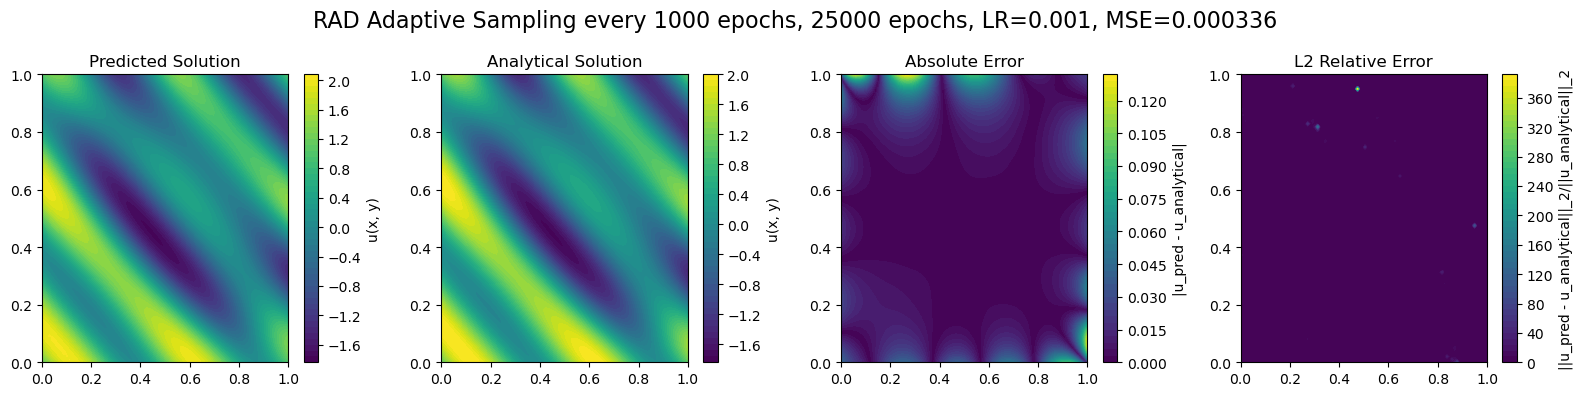

In [60]:
# Plotting: 
grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100))
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).to(device)

# Predict solution on the grid
with torch.no_grad():
    u_pred = model(grid_points).reshape(100, 100).cpu().numpy()

# Calculate analytical solution on the grid
x_vals = grid_x.cpu().numpy()
y_vals = grid_y.cpu().numpy()
u_analytical = analytical_solution(grid_x, grid_y).cpu().numpy()

# Plot the predicted solution
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.contourf(x_vals, y_vals, u_pred, levels=50)
plt.colorbar(label="u(x, y)")
plt.title(f"Predicted Solution")

# Plot the analytical solution
plt.subplot(1, 4, 2)
plt.contourf(x_vals, y_vals, u_analytical, levels=50)
plt.colorbar(label="u(x, y)")
plt.title("Analytical Solution")

# Plot the absolute difference
plt.subplot(1, 4, 3)
plt.contourf(x_vals, y_vals, np.abs(u_pred - u_analytical), levels=50)
plt.colorbar(label="|u_pred - u_analytical|")
plt.title("Absolute Error")

# Plot the L2 relative error
plt.subplot(1, 4, 4)
l2_rel_error = np.sqrt((u_pred - u_analytical)**2) / np.sqrt(u_analytical**2)
plt.contourf(x_vals, y_vals, l2_rel_error, levels=50)
plt.colorbar(label="||u_pred - u_analytical||_2/||u_analytical||_2")
plt.title("L2 Relative Error")

mse = torch.mean((torch.tensor(u_pred) - torch.tensor(u_analytical))**2)
plt.suptitle(f'RAD Adaptive Sampling every 1000 epochs, 25000 epochs, LR=0.001, MSE={mse:.6f}', fontsize=16)
plt.tight_layout()
plt.savefig("pinn_RAD.pdf", format="pdf")
plt.show()

In [61]:
# evaluate output in (0.5, 0.5)
model(torch.tensor([0.4, 0.2], device=device))

tensor([1.4853], device='mps:0', grad_fn=<LinearBackward0>)

In [62]:
# Mean squared error of solution
mse = torch.mean((torch.tensor(u_pred) - torch.tensor(u_analytical))**2)
print(f"Mean Squared Error: {mse:.6f}")
# MSE 50000 epochs 0.0001 LR 0.0001 is 0.000623
# random boundary points Mean Squared Error: 0.001286


Mean Squared Error: 0.000336
